In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, Input, Dense, TimeDistributed, RepeatVector, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import seaborn as sns

### Data load

In [2]:
url = 'https://raw.githubusercontent.com/JunetaeKim/DeepLearningClass/main/Dataset/10LetterWords.txt'
Dataset = pd.read_csv(url, header=None)


In [3]:
Dataset

,0
0,abbreviate
1,abdication
2,aberration
3,abjuration
4,abnegation
...,...
2561,wrongdoing
2562,xenophobia
2563,xerography
2564,yesteryear


### Alphabet table generation

In [4]:
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# create mapping of characters to integers (0-25) and the reverse
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

# one-hot encoding for alphabets
AlphTab = pd.DataFrame(char_to_int,index = [0]).T
AlphOneHot =  pd.get_dummies(AlphTab[0])

### Data encoding; alphabet to numeric values

In [5]:
AlphaEncode = []
for word in Dataset.values:
    SubVec = []
    for char in word[0]:
        CharIDX = char_to_int[char.upper()]
        SubVec.append(AlphOneHot.iloc[CharIDX].values[None])
    SubVec = np.concatenate(SubVec, axis=0)
    AlphaEncode.append(SubVec[None])
AlphaEncode = np.concatenate(AlphaEncode)

### Data selection

In [6]:
### Data selection for input and output 
InpData = AlphaEncode[:,:7, :] # Five input alphabets
TargetData = AlphaEncode[:,7:, :] # Five output alphabets

### Model save directory setting

In [7]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

### Model definition

In [8]:
def WordsModel ():
    InpL = Input(shape=(InpData.shape[1], InpData.shape[2]))
    LSTML = LSTM(30, return_sequences=True)(InpL)
    LSTMOut = LSTM(30, return_sequences=False)(LSTML)

    LSTMOut = RepeatVector(TargetData.shape[1])(LSTMOut)
    Output = TimeDistributed(Dense(30))(LSTMOut)
    Output = LSTM(30, return_sequences=True)(Output)
    Output = Dense(InpData.shape[2], activation='softmax')(Output)
    return Model(InpL,Output)   
    

In [9]:
### Model checkpoint
ModelSaveSameName = save_path+'10LetterWordM.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='loss', verbose=1, save_best_only=True)

### Model Early stop
EarlyStop = EarlyStopping(monitor='loss', patience=100)

WordsM = WordsModel()
WordsM.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam', metrics =['accuracy'])
WordsMHist = WordsM.fit(InpData, TargetData,  epochs=2000, batch_size=100,  verbose=1, callbacks=[ModelSave, EarlyStop])

Epoch 1/2000
26/26 [==============================] - 3s 7ms/step - loss: 3.2361 - accuracy: 0.0957

Epoch 00001: loss improved from inf to 3.20217, saving model to ./Results\10LetterWordM.hdf5
Epoch 2/2000
26/26 [==============================] - 0s 8ms/step - loss: 2.9308 - accuracy: 0.1222

Epoch 00002: loss improved from 3.20217 to 2.86335, saving model to ./Results\10LetterWordM.hdf5
Epoch 3/2000
26/26 [==============================] - 0s 8ms/step - loss: 2.7206 - accuracy: 0.2123

Epoch 00003: loss improved from 2.86335 to 2.70496, saving model to ./Results\10LetterWordM.hdf5
Epoch 4/2000
26/26 [==============================] - 0s 7ms/step - loss: 2.6558 - accuracy: 0.2271

Epoch 00004: loss improved from 2.70496 to 2.62585, saving model to ./Results\10LetterWordM.hdf5
Epoch 5/2000
26/26 [==============================] - 0s 7ms/step - loss: 2.5904 - accuracy: 0.2287

Epoch 00005: loss improved from 2.62585 to 2.57487, saving model to ./Results\10LetterWordM.hdf5
Epoch 6/2000
2

### Model weight load and evaluate it

In [10]:
WordsM = WordsModel()
WordsM.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam', metrics =['accuracy'])
print('Before loading weights')
print(WordsM.evaluate(InpData, TargetData, batch_size=300 ))
print()

WordsM.load_weights(ModelSaveSameName)
print('After loading weights')
print(WordsM.evaluate(InpData, TargetData, batch_size=300))

Before loading weights
9/9 [==============================] - 1s 4ms/step - loss: 3.2579 - accuracy: 0.0319
[3.2579758167266846, 0.029877889901399612]

After loading weights
9/9 [==============================] - 0s 4ms/step - loss: 0.1392 - accuracy: 0.9361
[0.1391867846250534, 0.9360873103141785]


### Plot loss graphs

Text(0, 0.5, 'loss')

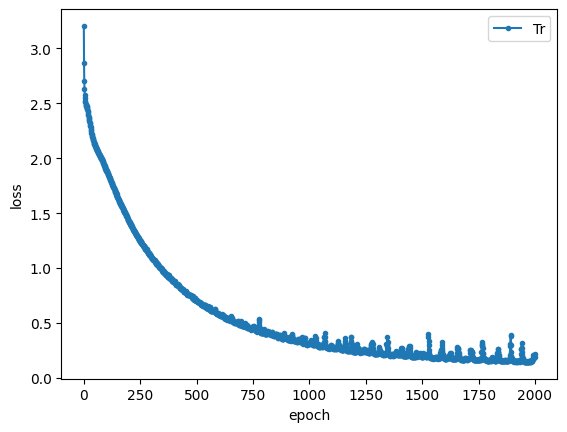

In [11]:
plt.plot(WordsMHist.history['loss'], label='Tr', marker='.')
plt.legend() 
plt.xlabel('epoch')
plt.ylabel('loss')

In [12]:
Dataset.head()

,0
0,abbreviate
1,abdication
2,aberration
3,abjuration
4,abnegation


### Prediction example

 abbrevi


<AxesSubplot:>

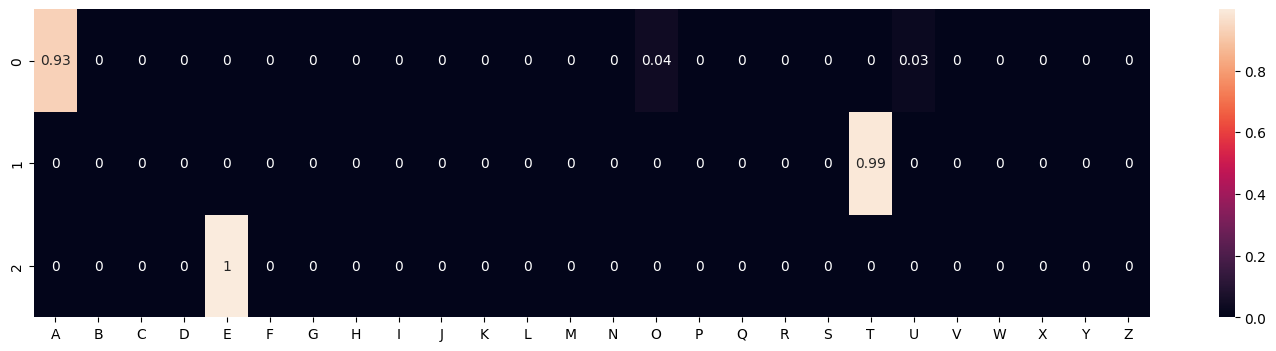

In [13]:
AlphaInp = input().upper()
AlphaInpEncod = [AlphOneHot.values[char_to_int[i]][None] for i in AlphaInp ]
AlphaInpEncod = np.concatenate(AlphaInpEncod, axis=0)
AlphaPred = WordsM.predict(AlphaInpEncod[None])

plt.figure(figsize=(18,4))    
sns.heatmap(AlphaPred[0], xticklabels=[i for i in char_to_int], annot=np.round(AlphaPred[0], 2),linewidths=0)